In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.init import xavier_uniform_

In [ ]:
# Load data
file_path = '/content/501.csv'
data = pd.read_csv(file_path)

# Preprocess data
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['label'] = data['label'] - 1  # Adjust labels to start from 0

# Separate features and labels
X = data[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
y = data['label']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

batch_size = 64  # Adjust batch size to match TensorFlow's default if necessary

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [ ]:
# Define the model
class ActivityClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ActivityClassifier, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        # Initialize weights with Xavier uniform initialization
        xavier_uniform_(self.fc1.weight)
        xavier_uniform_(self.fc2.weight)
        xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # output without softmax
        return x

In [ ]:
# Initialize model, loss criterion, and optimizer
num_classes = 8  # Update as per the class count
model = ActivityClassifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Ensure learning rate matches TensorFlow's

In [ ]:
# Training and validation loop
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1, Train Loss: 0.3993, Validation Loss: 0.1726
Epoch 2, Train Loss: 0.2119, Validation Loss: 0.1486
Epoch 3, Train Loss: 0.1855, Validation Loss: 0.1397
Epoch 4, Train Loss: 0.1746, Validation Loss: 0.1351
Epoch 5, Train Loss: 0.1669, Validation Loss: 0.1336
Epoch 6, Train Loss: 0.1627, Validation Loss: 0.1298
Epoch 7, Train Loss: 0.1569, Validation Loss: 0.1308
Epoch 8, Train Loss: 0.1553, Validation Loss: 0.1274
Epoch 9, Train Loss: 0.1532, Validation Loss: 0.1281
Epoch 10, Train Loss: 0.1507, Validation Loss: 0.1259
Epoch 11, Train Loss: 0.1500, Validation Loss: 0.1244
Epoch 12, Train Loss: 0.1501, Validation Loss: 0.1239
Epoch 13, Train Loss: 0.1474, Validation Loss: 0.1250
Epoch 14, Train Loss: 0.1472, Validation Loss: 0.1246
Epoch 15, Train Loss: 0.1486, Validation Loss: 0.1244
Epoch 16, Train Loss: 0.1462, Validation Loss: 0.1237
Epoch 17, Train Loss: 0.1437, Validation Loss: 0.1252
Epoch 18, Train Loss: 0.1458, Validation Loss: 0.1226
Epoch 19, Train Loss: 0.1430, Validat

In [ ]:
# Evaluate the model on the test set
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.1207, Test Accuracy: 96.54%


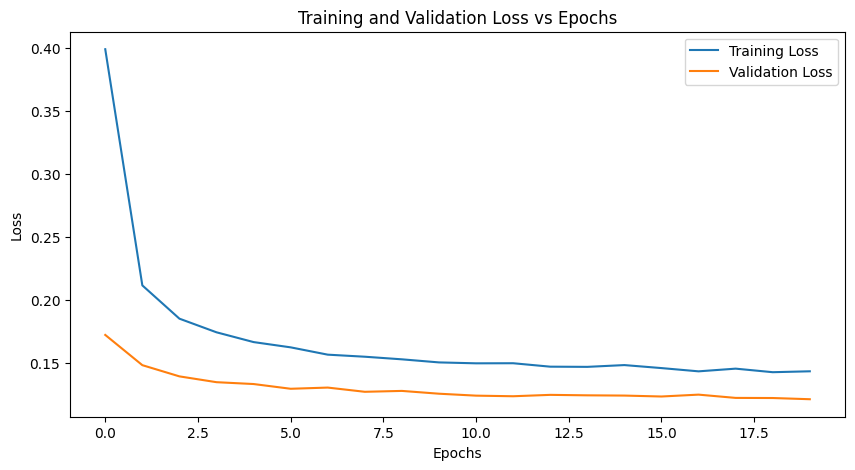

In [ ]:
# Plotting Training and Validation Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss_vs_epochs.png')
plt.show()

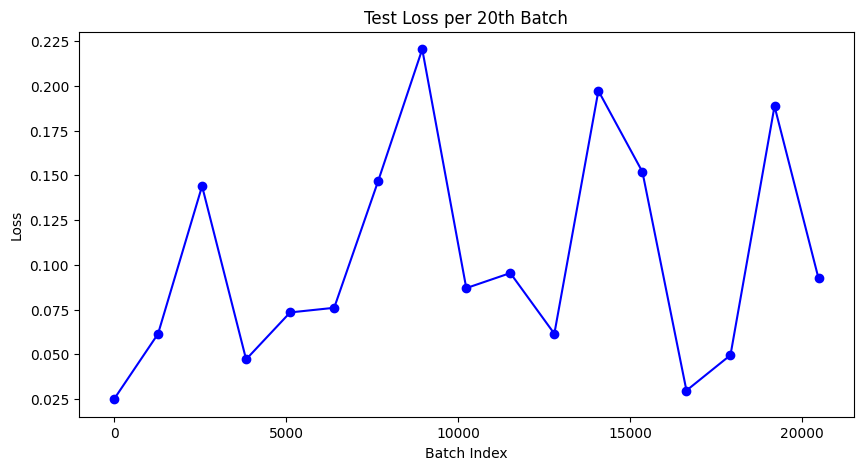

In [ ]:
# Plotting Test Loss per 20th Batch
test_loss_batches = []
test_indices = []
model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        if i % 20 == 0:  # every 20th batch
            loss = criterion(model(inputs), labels)
            test_loss_batches.append(loss.item())
            test_indices.append(i * batch_size)  # Using real indices

plt.figure(figsize=(10, 5))
plt.plot(test_indices, test_loss_batches, marker='o', linestyle='-', color='blue')
plt.title('Test Loss per 20th Batch')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.savefig('test_loss_per_20th_batch.png')  # Save the plot to a file
plt.show()